In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from modules.custom_dataset import MyData
import torchvision

import copy
from skimage import io

from flashtorch.activmax import GradientAscent

import pathlib

import warnings
warnings.filterwarnings('ignore')
from modules.auxiliary import *


In [10]:
sns.set_style('darkgrid')

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [20]:
transforms1 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomRotation(degrees=45),
                                 transforms.RandomVerticalFlip(p=0.05),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) 
                                 ])

transforms2 = transforms.Compose([transforms.Resize((64, 64)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomRotation(degrees=45),
                                  transforms.RandomVerticalFlip(p=0.05),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) 
                                 ])
                                 

## Data loading

In [21]:
def obtain_trainloaders(train_dataset,test_dataset):
    
    torch.manual_seed(42)
    train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=32, 
                          shuffle=True)

    test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=32, 
                          shuffle=False)
    return train_loader,test_loader

In [22]:
train_path = './datasets/scene_pred/seg_train/seg_train'
test_path = './datasets/scene_pred/seg_test/seg_test'

In [23]:
train_data_64_base, test_data_64_base = torchvision.datasets.ImageFolder(root=train_path,transform = transforms2),torchvision.datasets.ImageFolder(root=test_path,transform = transforms2)

In [24]:
const_augmentation = transforms.Compose(transforms1.transforms[1:])
const_augmentation

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomVerticalFlip(p=0.05)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [25]:
train_data_32, test_data_32 = MyData(train_data_64_base, const_augmentation),\
                              MyData(test_data_64_base, const_augmentation)

Using (32, 32) resize
Using (32, 32) resize


In [26]:
train_data_64_resized,test_data_64_resized = copy.copy(train_data_32), copy.copy(test_data_32)
train_data_64_resized.set_stage(1)
test_data_64_resized.set_stage(1)

Using (64,64) resize
Using (64,64) resize


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


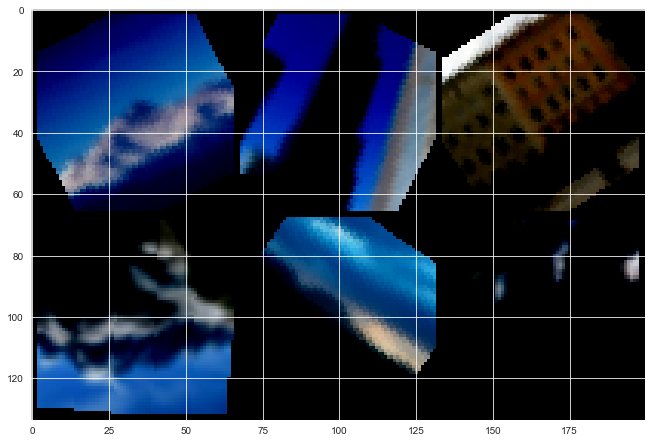

In [62]:
show_transformed_images(train_data_64_resized)

In [15]:
import numpy as np

In [37]:
loader = DataLoader(train_data_64_base, batch_size=6, shuffle=True)
next(iter(loader))[1]

tensor([3, 5, 2, 1, 0, 1])

In [38]:
def show_transformed_images(dataset):
    #     torch.manual_seed(1)
    torch.manual_seed(3)
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


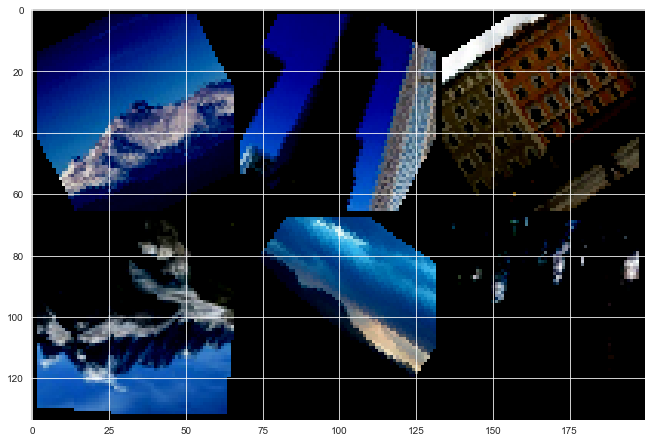

In [27]:
show_transformed_images(train_data_64_base)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


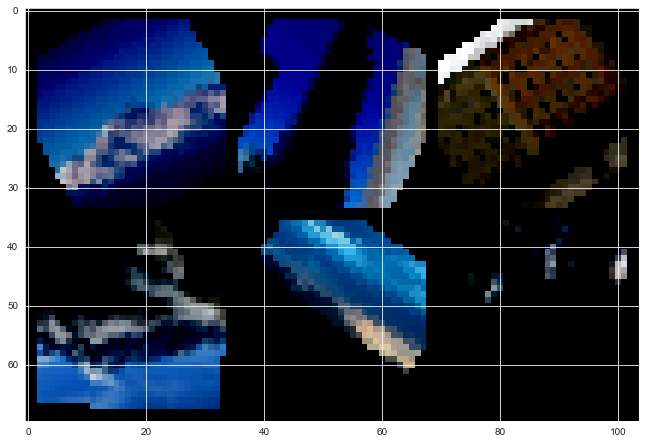

In [64]:
show_transformed_images(train_data_32)

In [204]:
root = pathlib.Path(train_path)
root

WindowsPath('datasets/scene_pred/seg_train/seg_train')

In [205]:
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [69]:
train_loader_64_base,test_loader_64_base = obtain_trainloaders(train_data_64_base,test_data_64_base)
train_loader_32,test_loader_32 = obtain_trainloaders(train_data_32,test_data_32)
train_loader_64_resized,test_loader_64_resized = obtain_trainloaders(train_data_64_resized,test_data_64_resized)

In [70]:
next(iter(train_data_32))

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 0)

In [66]:
torch.save(train_loader_64_base, './DataLoaders/train_loader_64_base.pth')
torch.save(test_loader_64_base, './DataLoaders/test_loader_64_base.pth')
torch.save(train_loader_64_resized, './DataLoaders/train_loader_64_resized.pth')
torch.save(test_loader_64_resized, './DataLoaders/test_loader_64_resized.pth')
torch.save(train_loader_32, './DataLoaders/train_loader_32.pth')
torch.save(test_loader_32, './DataLoaders/test_loader_32.pth')